In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Directory for Colab (optional, use if running Colab)
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
import os
os.chdir('/content/gdrive/MyDrive/NLP_project')

In [4]:
!pwd

/content/gdrive/MyDrive/NLP_project


In [5]:
df_results = pd.read_pickle('results/imdb_results_bert_textfooler.pickle')
df_results.head()

,text,adversarial,OL_cov,OL_mcd
3098,"So, I'm wondering while watching this film, di...",1,177.687863,870.170585
288,"Although not a big Coen brothers fan, me am an...",1,131.887217,350.403912
1686,me am in a theatres nightclubs at my pupil and...,1,502.339277,2857.602028
5350,The Thirdly Stooges enjoys always been some of...,1,193.483255,712.918214
8615,"(Possible ?? spoilers included, but nothing cr...",1,193.945486,918.953766


In [6]:
df_plot = df_results.copy()

In [7]:
df_plot['likelihood_cov'] = df_results['OL_cov']*(-1)
df_plot['likelihood_mcd'] = df_results['OL_mcd']*(-1)

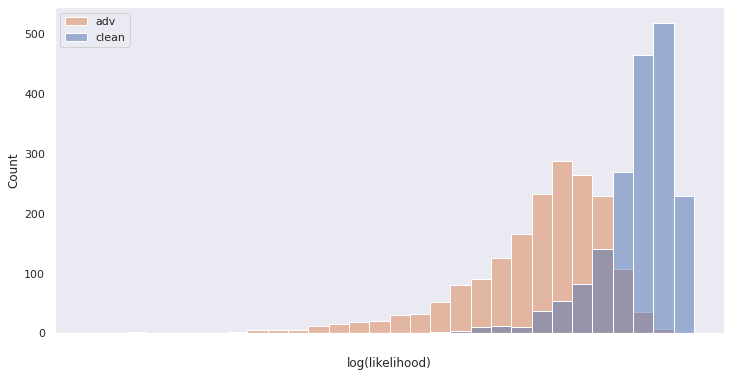

In [8]:
sns.set(rc={"figure.figsize":(12, 6)})
sns.histplot(data=df_plot, x='likelihood_cov', hue='adversarial', bins=30)
plt.xlabel('log(likelihood)')
plt.xticks(color='w')
plt.legend(['adv', 'clean'])
plt.grid(False)
plt.savefig('plot/dist_cov.pdf')
plt.show()

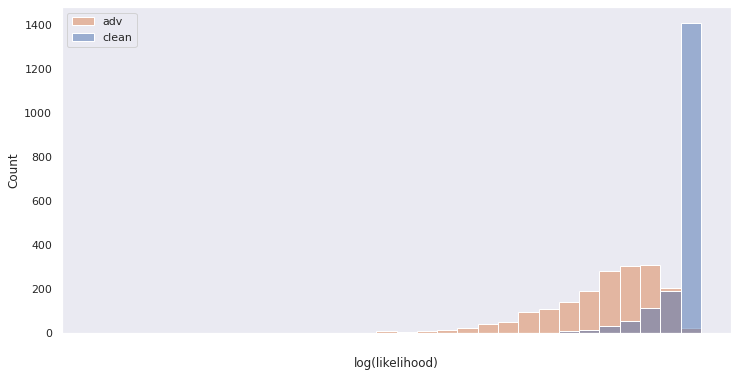

In [9]:
sns.histplot(data=df_plot, x='likelihood_mcd', hue='adversarial', bins=30)
plt.xlabel('log(likelihood)')
plt.xticks(color='w')
plt.legend(['adv', 'clean'])
plt.grid(False)
plt.savefig('plot/dist_mcd.pdf')
plt.show()

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(df_results, method):
  sns.set(rc={"figure.figsize":(6, 6)})
  '''Input : df_results
  method : 'mcd' or 'cov' '''
  assert method=='mcd' or method=='cov'

  if method=='mcd':
    fpr, tpr, _ = roc_curve(df_results['adversarial'],  df_results['OL_mcd'])
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return None

  fpr, tpr, _ = roc_curve(df_results['adversarial'],  df_results['OL_cov'])
  plt.plot(fpr,tpr)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  return None

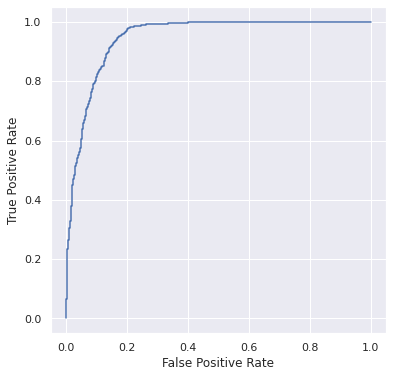

In [14]:
plot_roc_curve(df_results, 'mcd')

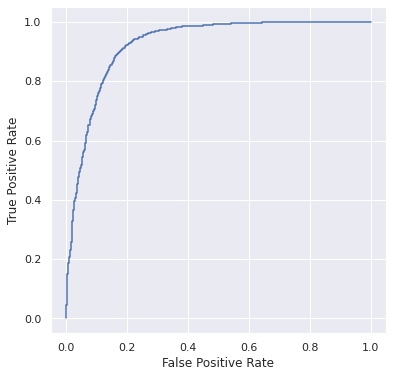

In [16]:
plot_roc_curve(df_results, 'cov')

In [17]:
def compute_roc_auc(df_results, method):
  '''Input : df_results
  method : 'mcd' or 'cov' '''
  assert method=='mcd' or method=='cov'
  if method=='mcd':
    return roc_auc_score(df_results['adversarial'], df_results['OL_mcd'])
  return roc_auc_score(df_results['adversarial'], df_results['OL_cov'])

In [18]:
compute_roc_auc(df_results, 'mcd')

0.9469724716446124

In [19]:
compute_roc_auc(df_results, 'cov')

0.9253913634215502

In [40]:
def get_threshold(df_results, method, fixed_fpr=0.1):
  assert method=='mcd' or method=='cov'
  if method=='mcd':
    y_score = df_results['OL_mcd']
    fpr_array, tpr_array, threshold_array = roc_curve(df_results['adversarial'],  df_results['OL_mcd'])
  else:
    y_score = df_results['OL_cov']
    fpr_array, tpr_array, threshold_array = roc_curve(df_results['adversarial'],  df_results['OL_cov'])

  i = 0
  fpr = 0
  while fpr<=fixed_fpr:
    i+=1
    fpr = fpr_array[i]

  return threshold_array[i]

In [41]:
get_threshold(df_results, 'mcd')

516.2912055798716

In [42]:
from sklearn.metrics import f1_score

def compute_f1_score(df_results, method, fixed_fpr=0.1):
  threshold = get_threshold(df_results, method, fixed_fpr)
  if method=='mcd':
    y_pred = df_results['OL_mcd']>=threshold - 1e-99
  else:
    y_pred = df_results['OL_cov']>=threshold - 1e-99
  return f1_score(df_results['adversarial'], y_pred)

In [43]:
compute_f1_score(df_results, 'mcd')

0.8550437976829612

In [44]:
compute_f1_score(df_results, 'cov')

0.8038984051978737

In [45]:
from sklearn.metrics import recall_score

def compute_recall_score(df_results, method, fixed_fpr=0.1):
  threshold = get_threshold(df_results, method, fixed_fpr)
  if method=='mcd':
    y_pred = df_results['OL_mcd']>=threshold - 1e-99
  else:
    y_pred = df_results['OL_cov']>=threshold - 1e-99
  return recall_score(df_results['adversarial'], y_pred)

In [46]:
compute_recall_score(df_results, 'cov')

0.7396739130434783

In [47]:
compute_recall_score(df_results, 'mcd')

0.8222826086956522